# ***Examen práctico parical 4***
### Luis Eduardo Jiménez del Muro - 12/05/2025
---

# **Paqueterías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier, LGBMRegressor, log_evaluation, early_stopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import shap

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

## *Funciones*

In [2]:
"""
Gráfica de las varianza explicada por cada componente
--------------------------------------------------------------------------------------------------------
"""
def plot_varianza_explicada(varianza_explicada):
    plt.figure(figsize=(10, 12))
    plt.barh(varianza_explicada.index, varianza_explicada[0], color='cadetblue', zorder=2, height=0.5)

    for i, v in enumerate(varianza_explicada[0]):
        plt.text(v + 0.001, i, f'{v:.2f}')

    plt.title('Varianza explicada por cada componente principal', fontsize=16, fontweight='bold')
    plt.xlabel('Varianza explicada')
    plt.ylabel('Componente principal')
    plt.grid(alpha=0.4, linestyle='--', axis='x', zorder=0)
    plt.show()


"""
Graficar el método del Codo
--------------------------------------------------------------------------------------------------------
"""
def elbow_method(data, max_clusers=11):
    inertias = []

    K_range = range(1, max_clusers)

    for i in K_range:
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=i, random_state=42))
        ])
        pipeline.fit(data)
        inertias.append(pipeline.named_steps['kmeans'].inertia_)

    plt.figure()
    plt.plot(K_range, inertias, marker='o', linestyle='--', color='cadetblue')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.grid(alpha=0.5, ls='--')
    plt.xticks(K_range)
    plt.show()


"""
Scatter plot de los componentes principales con KMeans
--------------------------------------------------------------------------------------------------------
"""
def plot_xcomponents_clusters(X_componentes, PCA1, PCA2):
    plt.figure()
    scatter = plt.scatter(X_componentes[PCA1], X_componentes[PCA2], s=20, c=X_componentes['cluster'], cmap='viridis', zorder=2)
    plt.title('Scatter plot de los componentes principales con KMeans')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(scatter, label='Cluster', ticks=[1, 2, 3])
    plt.grid(alpha=0.4, linestyle='--', zorder=0)
    plt.show()


"""
Clusterización
--------------------------------------------------------------------------------------------------------
"""
def cluster(X, n_clusters):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
    ])
    pipeline.fit(X)
    return pipeline.named_steps['kmeans'].labels_ + 1


"""
Roc Curve
--------------------------------------------------------------------------------------------------------
"""
def roc_curve_graph(probabilidades, y):
    fpr, fpn, scores = roc_curve(y_score=probabilidades, y_true=y)

    plt.title('ROC Curve')
    plt.plot(fpr, fpn, label='Modelo', color='cadetblue', lw=2)
    plt.plot([0, 1], [0, 1], label='Real', color='red', lw=1.5)
    plt.xlabel("1-specificty")
    plt.ylabel("sensitivity")
    plt.legend(loc='best')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


"""
Histograma de probabilidades
--------------------------------------------------------------------------------------------------------
"""
def histograma(probabilidades, y):
    resultados = pd.DataFrame({'y':y, 'probabilidades': probabilidades})

    sns.histplot(resultados[resultados['y'] == 0]['probabilidades'], stat='density', 
                 color='seagreen', alpha=0.40, kde=True, bins=20, edgecolor=None, label='0')
    sns.histplot(resultados[resultados['y'] == 1]['probabilidades'], stat='density', 
                 color='cadetblue', alpha=0.65, kde=True, bins=20, edgecolor=None, label='1')
    plt.title('Histograma de probabilidades')
    plt.legend(loc='best')
    plt.xlabel('Probabilidades')
    plt.ylabel('Frecuencia')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


"""
Importance Plot
--------------------------------------------------------------------------------------------------------
"""
def importance_plot(features, importance, type, n_features=10):
    df_importancia = pd.DataFrame({
        'features': features, 
        'importance': importance}).sort_values(by='importance', ascending=True)
    
    plt.barh(df_importancia['features'].tail(n_features), df_importancia['importance'].tail(n_features), 
             color='cadetblue', zorder=2, height=0.4)
    for i, v in enumerate(df_importancia['importance'].tail(n_features)):
        plt.text(v, i, f'{v:.4f}', color='black', fontsize=10)
    plt.title(f'{type}', fontweight='bold', fontsize=16)
    plt.grid(alpha=0.5, ls='--', axis='x', zorder=0)
    plt.show()


"""
Ajuste de LightGBM
--------------------------------------------------------------------------------------------------------
"""
def lgbm(X_train, y_train, X_test, y_test):

    model = LGBMClassifier(
        n_estimators=100_000,
        max_depth=6,
        learning_rate=0.1,
        lambda_l2=0.1,
        metric='auc',
        feature_fraction=0.8,
        subsample=0.5,
        num_leaves=6,
        n_jobs=-1,
        random_state=42,
        verbosity=-1
    )

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                callbacks=[early_stopping(50), log_evaluation(100)], eval_metric='auc')

    predicciones = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predicciones)

    gain = model.booster_.feature_importance(importance_type='gain')

    return model, predicciones, auc, gain

# **1. PCA**

## *Preparar los datos*

In [3]:
data = pd.read_csv('data/hr_role.csv')
data['Attrition'] = data['Attrition'].map({'Yes': True, 'No': False})
data = pd.get_dummies(data)

target = 'Attrition'
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

## *Escalar los datos y obtener el objeto PCA*

In [4]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

## *Varianzas explicada por componente*

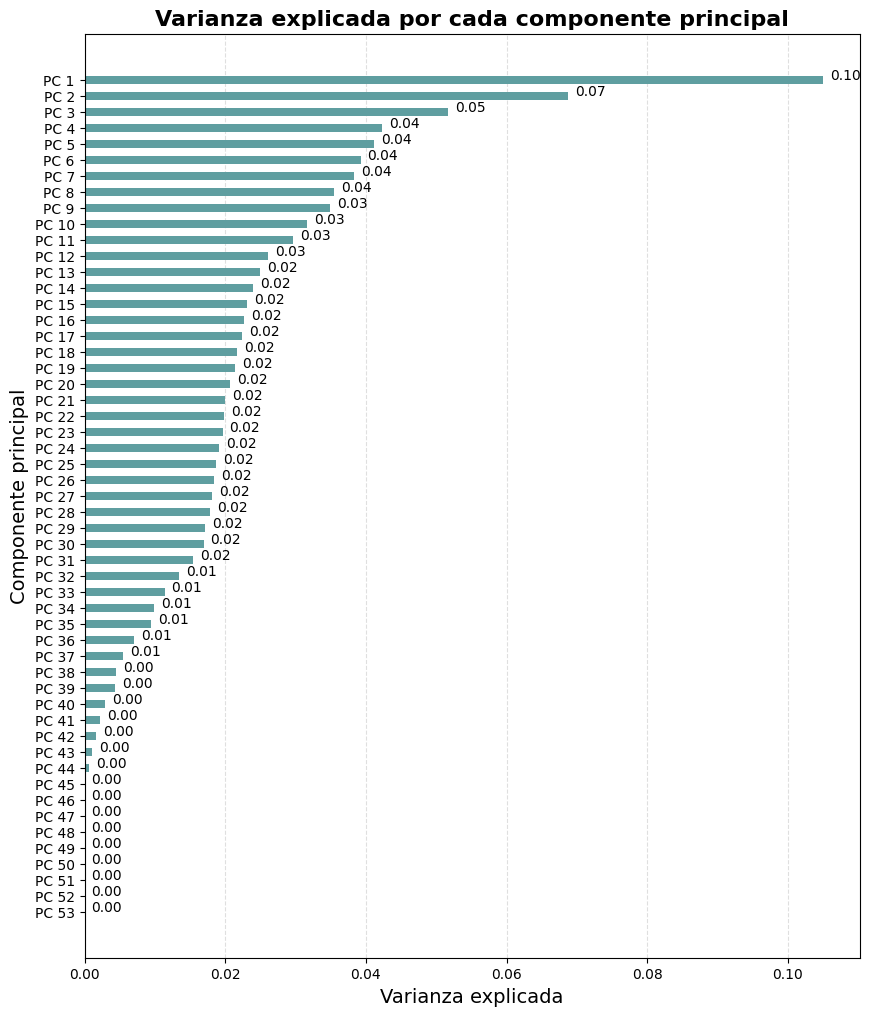

In [5]:
objeto_pca = pipeline.named_steps['pca']
X_pca = pipeline.transform(X)

X_componentes = pd.DataFrame(X_pca, columns=[f'PC {i+1}' for i in range(X.shape[1])])
varianza_explicada = pd.DataFrame([explicacion for explicacion in objeto_pca.explained_variance_ratio_]).T
varianza_explicada.columns = [f'PC {i+1}' for i in range(X.shape[1])]
varianza_explicada = varianza_explicada.T.sort_values(by=0, ascending=True)

plot_varianza_explicada(varianza_explicada)

+ Luego de obtener todos los componentes principales de nuestro set de datos, observamos que aquellos que explican una mayor varianza son el PC1, PC2 y PC3. Los demás tienen un porcentaje de explicación del 4% o menor.

+ Los PC del 38 al 53 explican menos del 1% de la varianza, lo que indica que son componentes muy malos.

+ Interesante notar, que sumando el porcentaje de varianza explicada de las primeras 10 componentes, se alcanza un 50%. Lo que indica que Es posible pasar un conjunto de datos de 50 columnas a uno de 10 y seguir explicando el 50% de la varianza de los datos.

# **2. K-Means**

## *Método del codo*

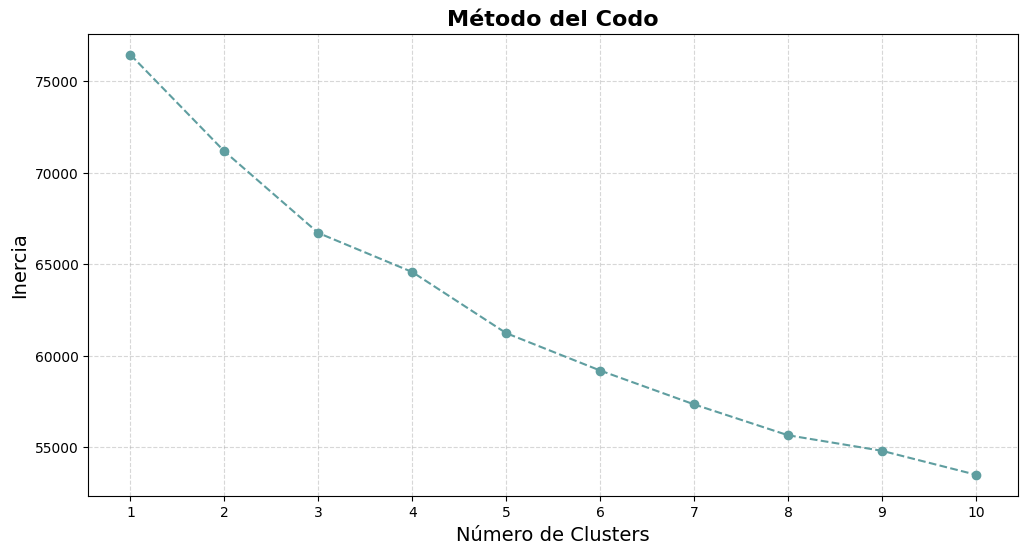

In [6]:
# Prueba del codo
elbow_method(data)

Gracias al método del codo podemos determinar que el número óptimo de clústeres sería utilizar 3. Por lo tanto esa cantidad se utilizará para la clusterización

## *Clusterización*

In [7]:
clusters = cluster(data, 3)
data['Cluster'] = clusters
data.groupby('Cluster').mean().T

Cluster,1,2,3
Age,35.150376,45.957529,34.913793
Attrition,0.220551,0.054054,0.166256
DailyRate,800.052632,809.146718,801.556650
DistanceFromHome,9.388471,8.976834,9.165025
Education,2.912281,3.100386,2.853448
EnvironmentSatisfaction,2.679198,2.698842,2.750000
HourlyRate,65.192982,66.030888,66.189655
JobInvolvement,2.696742,2.733591,2.745074
JobLevel,2.035088,3.884170,1.497537
MonthlyIncome,5911.969925,14807.872587,4144.327586


### Observaciones:

+ El cluster 1 tiene el mayor porcentaje de attrition, por lo que sería importante ver las características que tiene este clúster y tratar de buscar a que se debe esto.
    + En promedio son los que viven mas lejos del trabajo.
    + Son el cluster con menor satisfacción
    + Los roles de trabajadores en este cluster, son todos de JobRole_Sales Representative y JobRole_Sales Executive.
    + Un 30% de los empleados aprox pertenece a EducationField_Marketing, mientras que en los otros clústeres no hay casi nadie con ese campo de estudio.

# **3. Hacer Modelos**

## *a) lightgbm con las variables y explicar los shaps*

In [8]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.976085	valid_1's auc: 0.767622
[200]	training's auc: 0.99544	valid_1's auc: 0.784012
[300]	training's auc: 0.999215	valid_1's auc: 0.792257
Early stopping, best iteration is:
[268]	training's auc: 0.998559	valid_1's auc: 0.792861


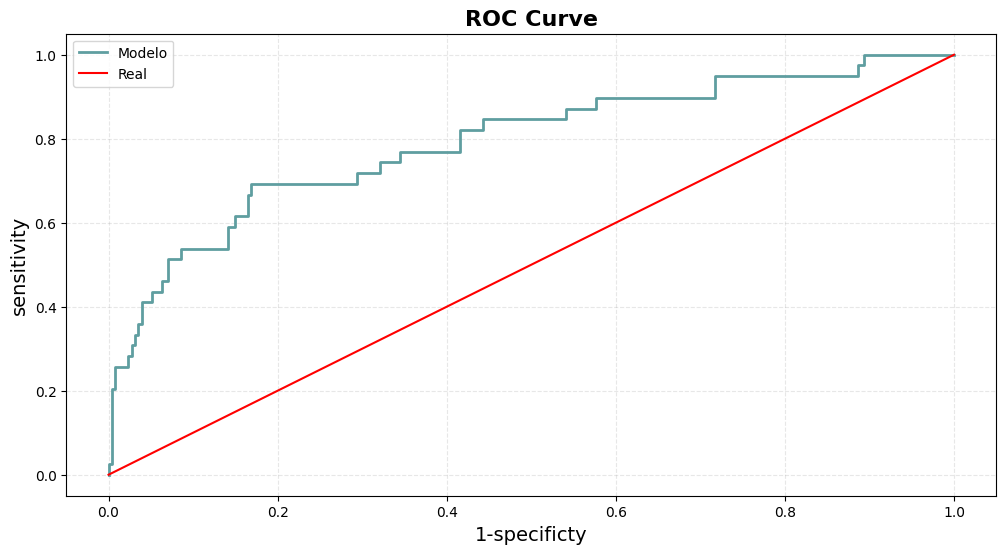

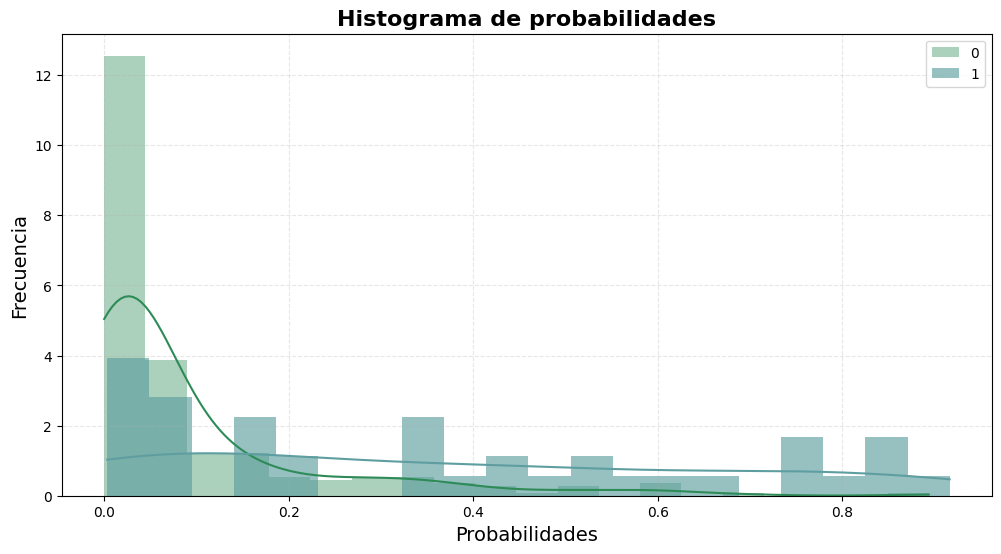

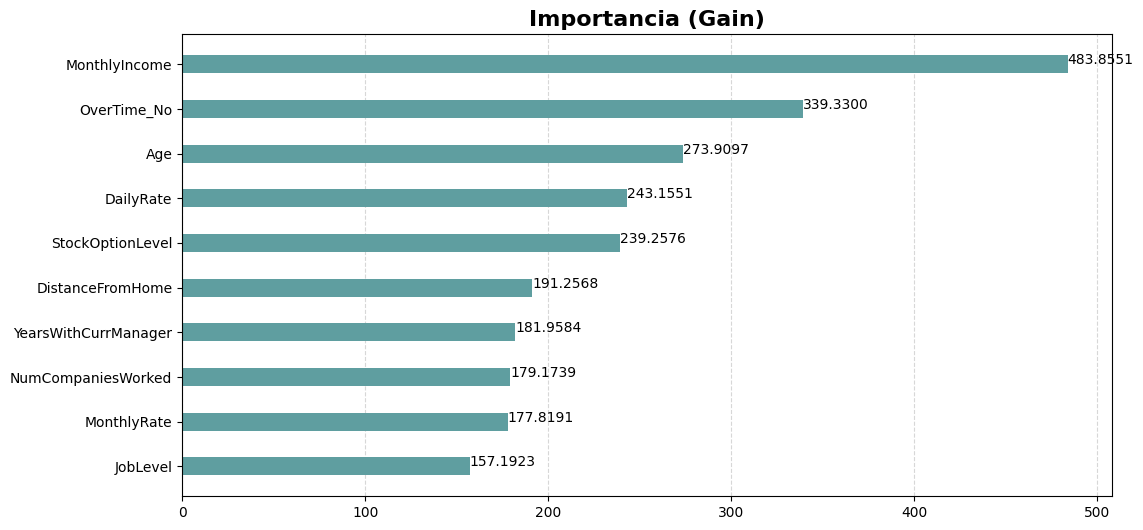


AUC del modelo: 0.7929


In [10]:
model, predicciones, auc, gain = lgbm(X_train, y_train, X_test, y_test)

roc_curve_graph(predicciones, y_test)
histograma(predicciones, y_test)
importance_plot(X.columns, gain, 'Importancia (Gain)', 10)
print(f'\nAUC del modelo: {auc:.4f}')

* El modelo con todas las variables logra un 0.79 de AUC aproximadamente, además, en el histograma de probabilidades se observa que el modelo tiene buena capacidad de clasificación. Su curva roc es amplia con respecto a la diagonal, lo cual indica que es un buen modelo.

* Gracias a la importancia (gain) en este modelo, observamos que las variables mas importantes para poder predecir si un empleado renunciaría a su trabajo son:
    + Si trabaja horas extras.
    + Su ingreso mensual.
    + Su edad.
    + Su nivel de accionariado en la empresa.

* Las demás variables son menos imporatnes en comparación a las anteriores.

### Shap values para una predicción en el conjunto de prueba

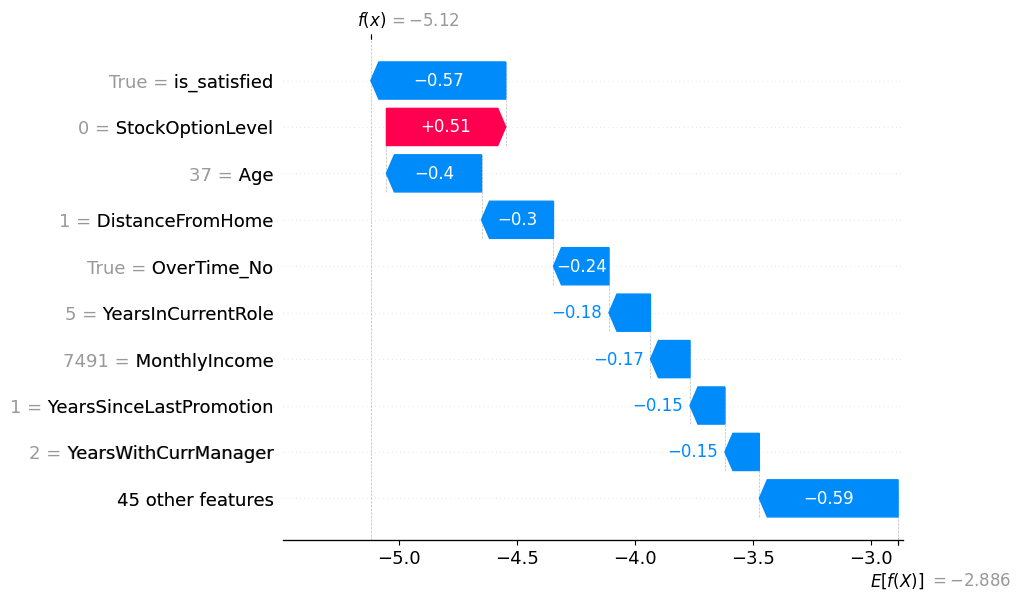

In [11]:
X_shap = X_test.copy()
X_shap = X_test.sample(int(len(X_test)*0.7), random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.initjs()
plt.figure()
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0], 
    base_values=explainer.expected_value, 
    data=X_shap.iloc[0], 
    feature_names=X_shap.keys()
))

* Para esta observación en específico, vemos que el modelo predeciría que este empleado no renunciaría, pues tiene cumple con muchas características que hace que el modelo reduzca su probabilidad abandonar.

* Por ejemplo, debido a que el empleado, se encuentra satisfecho, no trabaja horas extras, su edad es de 37 años, su distancia a casa es pequeña y otras características, hace que reduzcan drásticamente sus probabilidades de renunciar.

* Sin embargo cuenta con 2 importantes que le aumentan un poco su probabilidad, las cuales son que no tiene nivel en el accionariado de la empresa y su historial académico. Sin embargo, no es de grán importancia pues todas las demás variables deducen la probabilidad de renuncia.

### Shap values generales

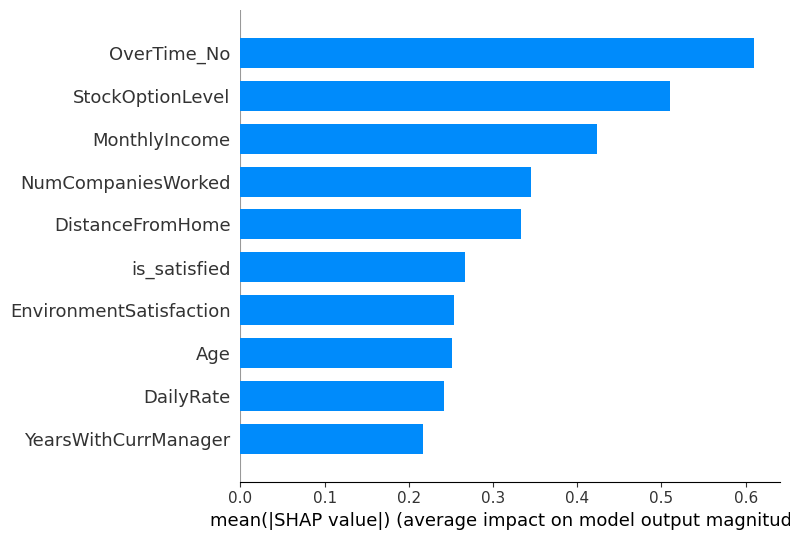

In [12]:
shap.summary_plot(shap_values, X_shap, plot_type="bar",  max_display=10)

+ Con esta gráfica vemos que las dos variables más importantes del modelo apara lograr una mejor clasificación son revisar si el trabajador trabaja horas extras y su nivel de acción en la empresa. 

+ Luego, aunque tienen menor impacto que las anteriores, se tendría al ingresio mensual, número de compañias en las que se ha trabajado anteriormente, distancia desde casa, entre otras. Todas estas hacen mucho sentido a explicar la razón por la que un empleado podría renunciar a su trabajo.

+ Otra que sorprendentemente no tiene tanto impacto en el modelo es si el empleado está satisfecho, sin embargo, esta variable podría estar explicada implíciatamente por las demás, y por ello reducir su importancia.

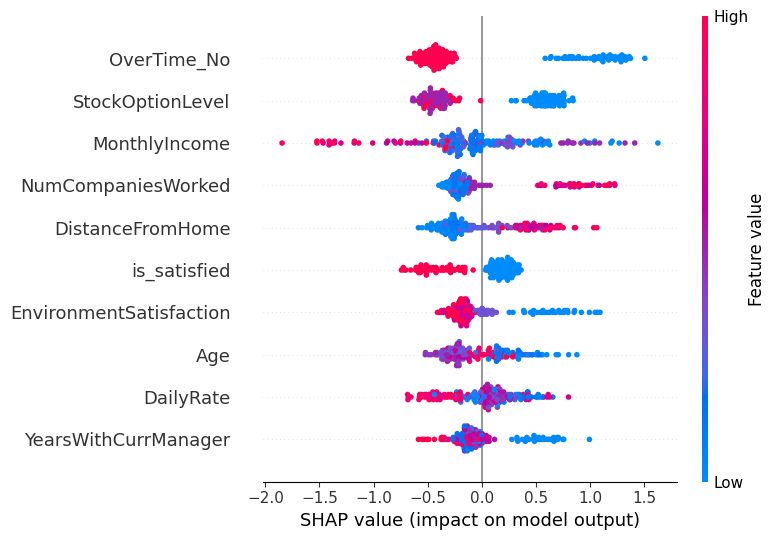

In [13]:
shap.summary_plot(shap_values, X_shap, plot_type='dot', max_display=10)

* Gracias al dotplot podemos observar de manera mas a como es que las variables con más importancia en el modelo afectan a la predicción. Vemos que la una de las que tiene más importancia es si tienen horas extras (OverTime_No), pues aquellos que no tienen horas extras reducen mucho la probabilidad de que el trabajador renuncie.

* De igual manera se observa una división muy clara en si el trabajador está satisfecho (is_satisfied), pues aquellos satisfechos reducen la probabilidad de renunciar.

* Aunque en las demás variables no se observan separaciones tan claras como en las 2 que ya se mencionaron, tambien podríamos destacar que: vivir cerca del trabajo, haber trabajado en pocas compañías anteriormente y tener un nivel más alto en las acciones de la empresa reducen considerablemente las probabilidades de renunciar.

## *b) lightgbm con las componentes principales, cuantas son buenas?*

In [14]:
X_train_componentes = X_componentes.loc[X_train.index]
X_test_componentes = X_componentes.loc[X_test.index]

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.996736	valid_1's auc: 0.768627
Early stopping, best iteration is:
[110]	training's auc: 0.997971	valid_1's auc: 0.777275


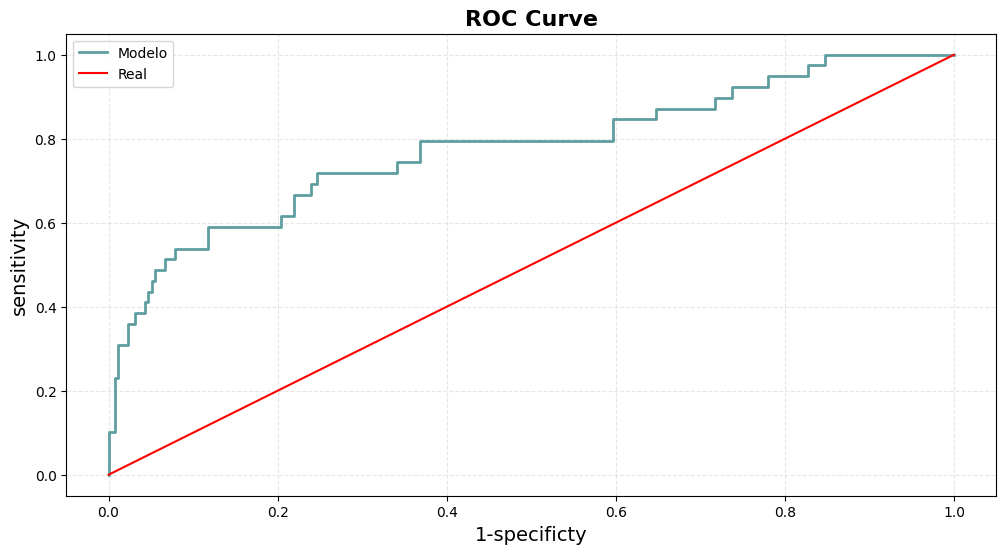

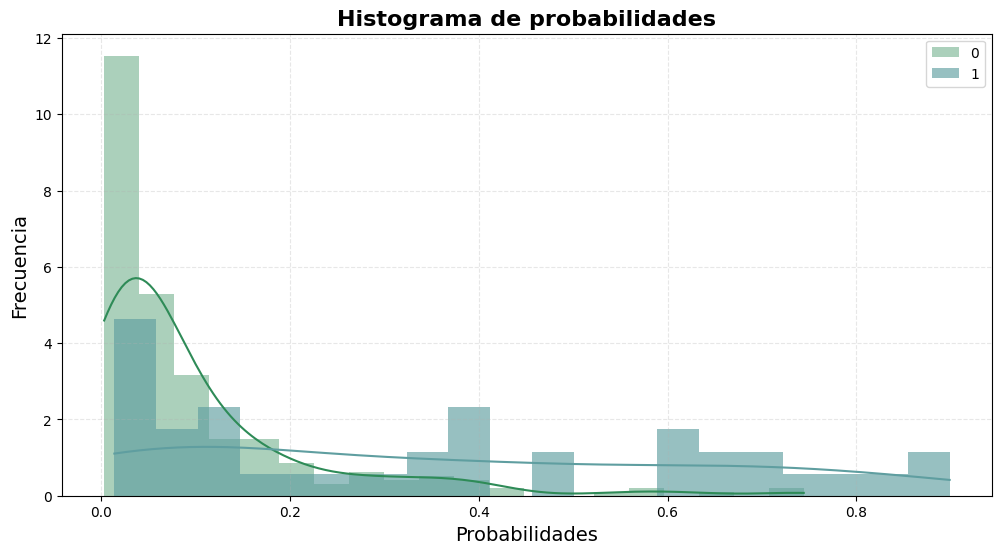

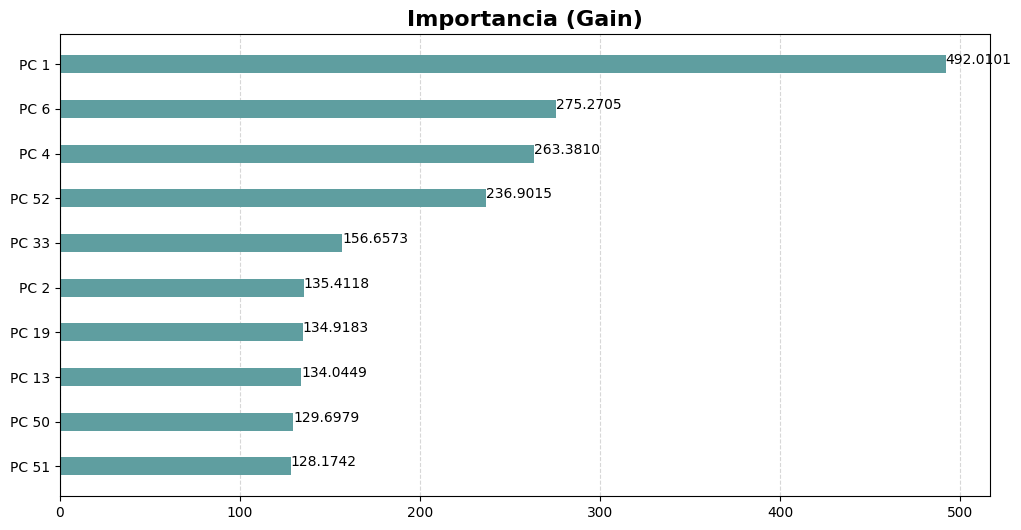


AUC del modelo: 0.7773


In [15]:
model, predicciones, auc, gain = lgbm(X_train_componentes, y_train, X_test_componentes, y_test)

roc_curve_graph(predicciones, y_test)
histograma(predicciones, y_test)
importance_plot(X_train_componentes.columns, gain, 'Importancia (Gain)', 10)
print(f'\nAUC del modelo: {auc:.4f}')

+ El desempeño de este modelo tuvo un resultado prácticamente igual al de todas las variables, con un AUC de 0.78 aproximandamente. Sin embargo, aun no se está reduciendo la dimensionalidad del los datos pues se utilizaron todos los componentes principales.

+ Según la gráfica de importancia, se observan 4 PCA que destacan de los demás, los cuales son el PC1, PC6, PC4 y el PC52. Estos se elegirán para desarrollar el modelo que únicamente utiliza los más importantes, pues a partir de ahí pierden mucha importancia los demás componentes y no sería tan importante integrarlos en el modelo.

## *c) lightgbm con las componentes más importantes*

In [16]:
X_3_componentes = X_componentes[['PC 1', 'PC 18', 'PC 30', 'PC 4']]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_3_componentes, y, test_size=0.2, random_state=42)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.912182	valid_1's auc: 0.683761
Early stopping, best iteration is:
[55]	training's auc: 0.865978	valid_1's auc: 0.693464


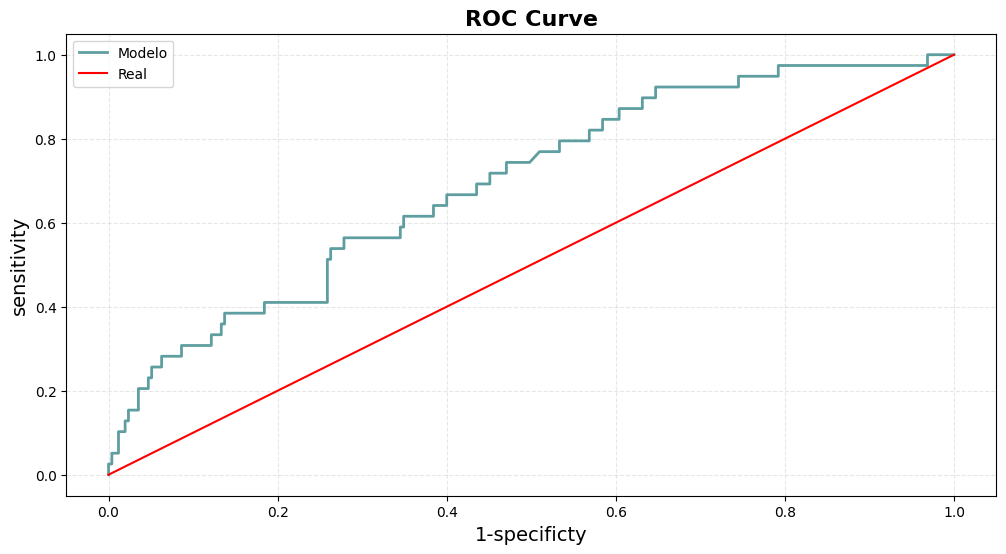

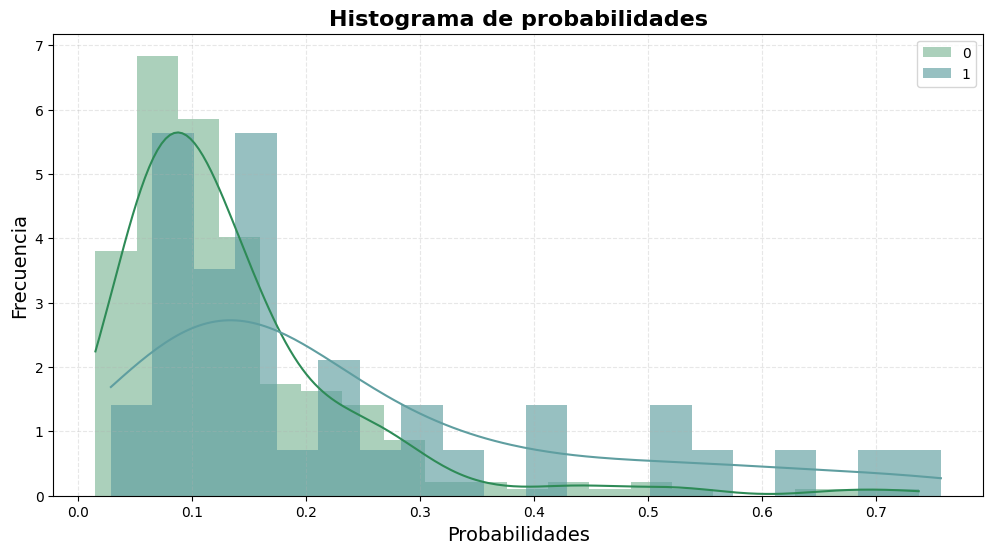

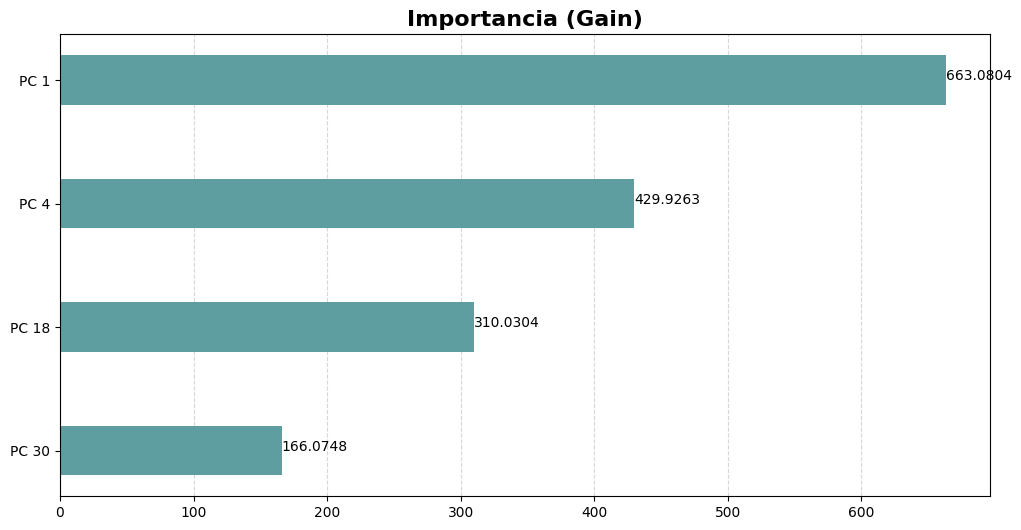


AUC del modelo: 0.6935


In [18]:
model, predicciones, auc, gain = lgbm(X_train, y_train, X_test, y_test)

roc_curve_graph(predicciones, y_test)
histograma(predicciones, y_test)
importance_plot(X_3_componentes.columns, gain, 'Importancia (Gain)', 10)
print(f'\nAUC del modelo: {auc:.4f}')

In [19]:
0.6935/0.7907-1

-0.12292905020867584

* Usando únicamente las componentes que fueron más importantes en el modelo pasado, se obtiene el modelo con peor resultado en términos de AUC, pues logra un 0.69 aproximadamente.

* En este caso, en el histograma de probabilidades se observa que el modelo no tiene una grán capacidad de clasificación y en la curva roc vemos que está muy cerca de la diagonal. Lo que indica que quizá en este caso no tan buena idea reducir la dimensionalidad.

* Si se quisiera hacer un modelo rápido y que no consuma mucho computacionalmente pues entonces este modelo no sería tan mala idea, pues tan solo es un 12% peor en términos de AUC que el que tiene todas las variables.

# **4. Dataset de Diabetes**

## *S-Learner*

In [20]:
data = pd.read_csv('data/diabetes.csv')
data = pd.get_dummies(data, columns=['gender'])
data['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [21]:
map_conditions = {
    'never':False, 'No Info':False, 
    'current':True, 'former':True, 'ever':True, 'not current':True
}

data['smoking_history'] = data['smoking_history'].map(map_conditions)
data.head()

,age,hypertension,heart_disease,smoking_history,bmi,diabetes,gender_Female,gender_Male,gender_Other
0,80.0,0,1,False,25.19,0,True,False,False
1,54.0,0,0,False,27.32,0,True,False,False
2,28.0,0,0,False,27.32,0,False,True,False
3,36.0,0,0,True,23.45,0,True,False,False
4,76.0,1,1,True,20.14,0,False,True,False


In [22]:
target = 'diabetes'
X = data.copy()
X = data.drop(target, axis=1)
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
model, predicciones, auc, gain = lgbm(X_train, y_train, X_test, y_test)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.836631	valid_1's auc: 0.835719
Early stopping, best iteration is:
[115]	training's auc: 0.837172	valid_1's auc: 0.836016


In [24]:
X_test_counter0 = X_test.copy()
X_test_counter0['smoking_history'] = 0

X_test_counter1 = X_test.copy()
X_test_counter1['smoking_history'] = 1

In [25]:
df_cate = pd.DataFrame({
    'treatment0': model.predict_proba(X_test_counter0)[:,1],
    'treatment1': model.predict_proba(X_test_counter1)[:,1]
})
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate['bins_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes'] = y_test

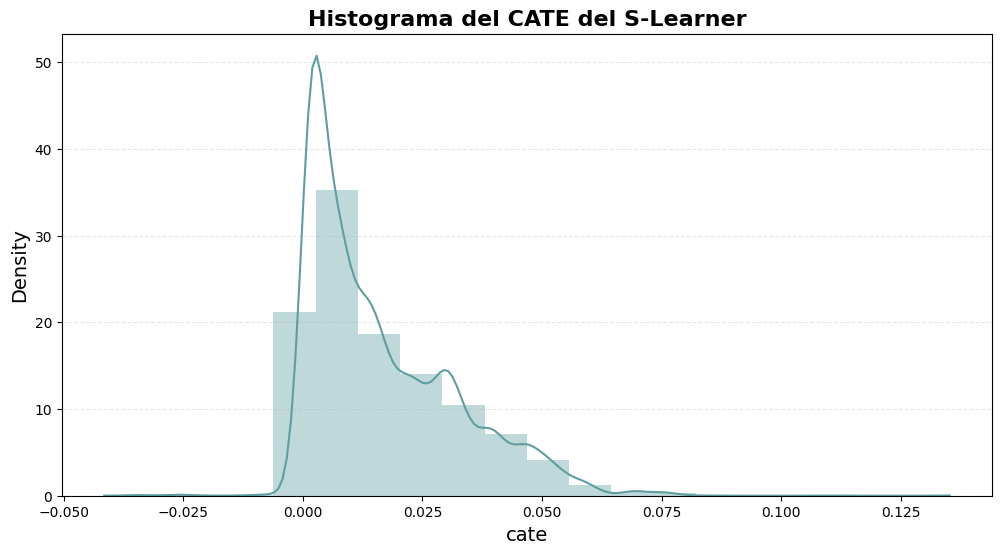

In [26]:
sns.histplot(df_cate['cate'], stat='density', 
                 color='cadetblue', alpha=0.40, kde=True, bins=20, edgecolor=None, label='0')
plt.grid(alpha=0.3, ls='--', axis='y', zorder=0)
plt.title('Histograma del CATE del S-Learner')
plt.show()

In [27]:
df_cate.groupby('bins_cate').mean()

,treatment0,treatment1,cate,diabetes
bins_cate,,,,
1,0.009964,0.011160,0.001196,0.075309
2,0.013004,0.018104,0.005101,0.087011
3,0.042222,0.053882,0.011660,0.087952
4,0.093727,0.116463,0.022737,0.099741
5,0.225279,0.267234,0.041955,0.093481


* Gracias al histograma vemos que la mayoría de los datos se encuentran del lado positivo, lo que indica que en general si hay un impacto de fumar sobre tener diabetes, aunque no tan grande, pues no se obtiene un impacto mayor al 12% aproximadamente

* Luego de agrupar en bins el CATE del S-Learner, observamos que en general no se detecta un impacto tan grande de fumar sobre padecer diabetes. Vemos que en el bin 5 se observa el mayor impacto con un 4.19% en promedio, pues este sería la cola derecha de la distribución, y como vemos en el histograma, la distribución del CATE está sesgada, lo que significa, que si hay muchos datos que presentan impactos entre el 1% y 7%. 

* No obstante, los otros 4 bins tienen impactos entre 0% y 1%, lo que podría indicar que hay un factor en los fumadores que podría estar incrementando sus probabilidades de tener diabetes y que otros fumadores no tienen.

## *T-Learner*

In [28]:
# Train: Smoke = 1
X_train_smoke1 = X_train[X_train['smoking_history'] == 1]
y_train_smoke1 = y_train.loc[X_train_smoke1.index]

# Train: Smoke = 0
X_train_smoke0 = X_train[X_train['smoking_history'] == 0]
y_train_smoke0 = y_train.loc[X_train_smoke0.index]

# Test: Smoke = 1
X_test_smoke1 = X_test[X_test['smoking_history'] == 1]
y_test_smoke1 = y_test.loc[X_test_smoke1.index]

# Test: Smoke = 0
X_test_smoke0 = X_test[X_test['smoking_history'] == 0]
y_test_smoke0 = y_test.loc[X_test_smoke0.index]

In [29]:
model_t0, predicciones, auc, gain = lgbm(X_train_smoke0, y_train_smoke0,
                                         X_test_smoke0, y_test_smoke0)

model_t1, predicciones, auc, gain = lgbm(X_train_smoke1, y_train_smoke1,
                                         X_test_smoke1, y_test_smoke1)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.849904	valid_1's auc: 0.848244
[200]	training's auc: 0.854252	valid_1's auc: 0.848056
Early stopping, best iteration is:
[157]	training's auc: 0.852673	valid_1's auc: 0.848525
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.799013	valid_1's auc: 0.79495
Early stopping, best iteration is:
[117]	training's auc: 0.800197	valid_1's auc: 0.795269


In [30]:
todos = X_test.copy()
todos = todos[X_train_smoke0.keys()]

df_cate = pd.DataFrame({
    'treatment0': model_t0.predict_proba(todos)[:,1],
    'treatment1': model_t1.predict_proba(todos)[:,1]
})
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate['bins_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes'] = y_test

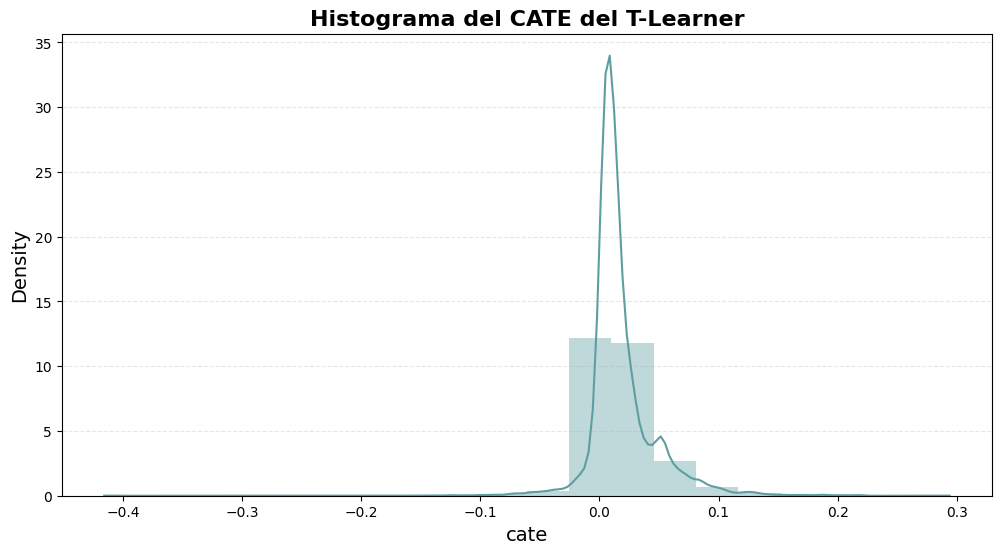

In [31]:
sns.histplot(df_cate['cate'], stat='density', 
                 color='cadetblue', alpha=0.40, kde=True, bins=20, edgecolor=None, label='0')
plt.grid(alpha=0.3, ls='--', axis='y', zorder=0)
plt.title('Histograma del CATE del T-Learner')
plt.show()

In [32]:
df_cate.groupby('bins_cate').mean()

,treatment0,treatment1,cate,diabetes
bins_cate,,,,
1,0.084061,0.076460,-0.007601,0.092732
2,0.021379,0.027530,0.006152,0.071515
3,0.034720,0.046519,0.011799,0.090134
4,0.073223,0.094403,0.021180,0.094315
5,0.169108,0.229320,0.060212,0.095000


* Luego de realizar el T-Learner se observa una distribución en el cate muy distinta a la del S-Learner, pues esta presenta una mayor cantidad de valores atípicos que van desde el -40% hasta el 30%.

* Sin embaro, nuevamente observamos que la mayoría de los datos están centrados en el 0% con un leve sesgo, que muestra que hay más datos del lado positivo.

* Al momento de dividir en bins se observa que este modelo detectó un impacto mayor de fumar en comparación al S-Learner, pues ahora los bins 3, 4 y 5 tienen CATES promedios mayores al 1%, lo que indica que aunque es bajo, fumar si tiene un impacto sobre la diabetes.

## *X-Learner*

In [33]:
D0 = y_train_smoke1 - model_t0.predict(X_train_smoke1)
D1 = model_t1.predict(X_train_smoke0) - y_train_smoke0

In [34]:
mD0 = LGBMRegressor(
    n_estimators=100_000,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.8,
    subsample=0.5,
    num_leaves=6,
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    metric='rmse'
)
mD0.fit(X_train_smoke1, D0)

MD1 = LGBMRegressor(
    n_estimators=100_000,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.8,
    subsample=0.5,
    num_leaves=6,
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    metric='rmse'
)
MD1.fit(X_train_smoke0, D1)

LGBMRegressor(colsample_bytree=0.8, max_depth=6, metric='rmse',
              n_estimators=100000, n_jobs=-1, num_leaves=6, random_state=42,
              subsample=0.5, verbosity=-1)

In [35]:
X_train_ps = X_train.drop(columns=['smoking_history'])
X_test_ps = X_test.drop(columns=['smoking_history'])

y_train_smoke = X_train['smoking_history'].reset_index(drop=True)
y_test_smoke = X_test['smoking_history'].reset_index(drop=True)

propensity_model = LGBMClassifier(
    n_estimators=100_000,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.8,
    subsample=0.5,
    num_leaves=6,
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    metric='auc'
)
propensity_model.fit(X_train_ps, y_train_smoke,
                     eval_set=[(X_train_ps, y_train_smoke), (X_test_ps, y_test_smoke)],
                     callbacks=[early_stopping(25), log_evaluation(100)], eval_metric='auc')

Training until validation scores don't improve for 25 rounds
[100]	training's auc: 0.688823	valid_1's auc: 0.688723
Early stopping, best iteration is:
[116]	training's auc: 0.689386	valid_1's auc: 0.689285


LGBMClassifier(colsample_bytree=0.8, max_depth=6, metric='auc',
               n_estimators=100000, n_jobs=-1, num_leaves=6, random_state=42,
               subsample=0.5, verbosity=-1)

In [36]:
propensity_score = propensity_model.predict_proba(X_test_ps)[:, 1]

In [37]:
predict_d1 = MD1.predict(X_test)
predict_d0 = mD0.predict(X_test)

In [38]:
cate = propensity_score * predict_d1 + (1 - propensity_score) * predict_d0
df_cate = pd.DataFrame({
    'cate': cate
})
df_cate['bins_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes'] = y_test

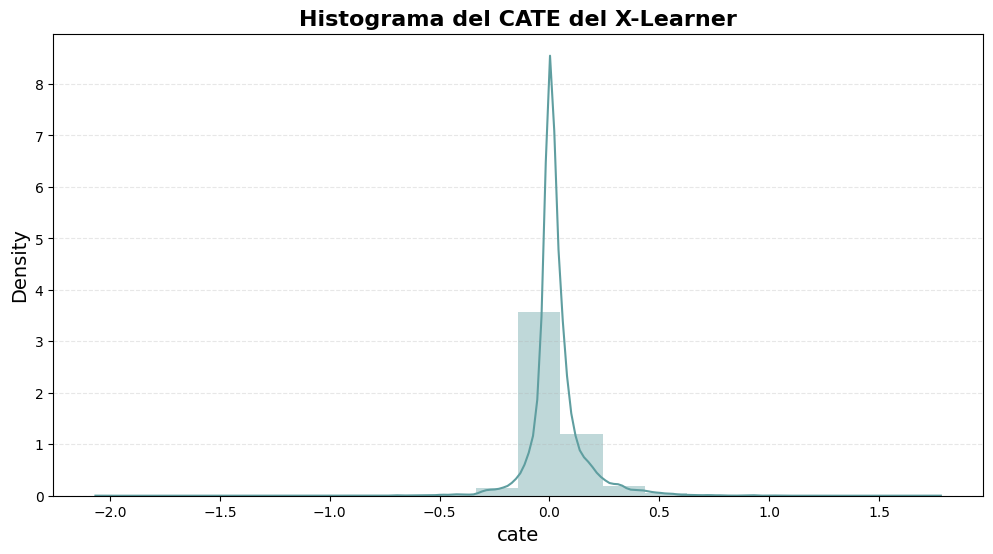

In [39]:
sns.histplot(df_cate['cate'], stat='density', 
                 color='cadetblue', alpha=0.40, kde=True, bins=20, edgecolor=None, label='0')
plt.grid(alpha=0.3, ls='--', axis='y', zorder=0)
plt.title('Histograma del CATE del X-Learner')
plt.show()

In [40]:
df_cate.groupby('bins_cate').mean()

,cate,diabetes
bins_cate,,
1,-0.095207,0.108209
2,-0.007342,0.070025
3,0.011497,0.090244
4,0.045626,0.090677
5,0.192388,0.084065


+ Se observa un patrón parecido al del T-Learner, sin embargo, este modelo está identificando una mayor causalidad en el bin 5 de la distribución del CATE, pues está promediando incluso hasta un 19%. 

+ Digual manera, los bins 3 y 4 son mayores al 1%, lo que sugiere que si existe un impacto en fumar sobre padecer diabetes.

+ La razón por la que este modelo da promedios más altos en los bins es por que se obtiene CATES muy extremos, desde -2 hasta 1.5, lo que puede ser que esté afectando un poco los resultados.

+ Nuevamente, vemos que la media se ve aproximadamente en cero, pero nuevamente sesgada, lo que implica que si existe un efecto causal en fumar sobre padecer diabetes.